# Obtain connectivity structure of silhouettes

## Helper function readout building block info

In [ ]:
# stupid readout function of text-based silhouette description of coordinate form
def make_ShapeCoord(trial_Shape,n_BBs=3,start_pos=4,verbose=False):

  BBs = []

  for idx_BB in np.arange(n_BBs):

    if verbose:
      print(idx_BB)

      print([int(trial_Shape[start_pos+(idx_BB*15)]),
                int(trial_Shape[start_pos+4+(idx_BB*15)]),
                int(trial_Shape[start_pos+9+(idx_BB*15)])])

    BBs.append([int(trial_Shape[start_pos+(idx_BB*15)]),
                int(trial_Shape[start_pos+4+(idx_BB*15)]),
                int(trial_Shape[start_pos+9+(idx_BB*15)])])
    
  return BBs

## Helper function obtain neighbour info of a given silhouette

In [ ]:
# Obtain coordinate and neighbour info for a given silhouette
# Expects shape of silhouette with building block info as input (see draw_silh() function below)
# important: y is dominant, find minimum y coordinate (row), then minimum x (column) therein
def mkCoords(final_Coord,n_blocks=4,verbose=False):

  coord_Blocks = np.zeros((n_blocks, 3))

  neighBours = np.zeros((n_blocks, 6)) # number blocks x number of neighbours to the (left, ontop, right, below, total number of unique neighbours)

  neighBour_Ident = np.multiply(np.ones((n_blocks, 5)),-1) # number blocks x neighbours to the (left, ontop, right, below, total number of unique neighbours)

  unique_vals = np.unique(final_Coord)
  unique_vals = unique_vals[1:] # get rid of zero
  unique_vals = unique_vals.astype(int)

  block_count = 0
  for idx_blocks in unique_vals:

    coords_Block = np.where(final_Coord==idx_blocks)

    coord_Blocks[block_count,1] = min(coords_Block[0])

    coord_Blocks[block_count,0] = min(coords_Block[1][np.where(coords_Block[0]==min(coords_Block[0]))])

    coord_Blocks[block_count,2] = idx_blocks-1 # -1 because we had to add one to differentiate from background (annoyed smiley)

    # find neighbours - this is inefficient coding but hopefully easier to read that way
    # find neighbouring grid elements (this doesn't work if we are at the border somewhere):
    coords_Block_x = coords_Block[1]
    coords_Block_y = coords_Block[0]
    coords_Block_left  = [x-1 for x in coords_Block_x]
    coords_Block_ontop = [y-1 for y in coords_Block_y]
    coords_Block_right = [x+1 for x in coords_Block_x]
    coords_Block_below = [y+1 for y in coords_Block_y]
    
    # now find left, ontop, right, below neighbours, also keep track of overall (unique) neighbouers
    all_neighbours = []

    neighbours_left = (final_Coord[tuple([coords_Block_y,coords_Block_left])])
    neighbours_left = neighbours_left[neighbours_left!=0]
    neighbours_left = neighbours_left[neighbours_left!=idx_blocks]
    neighbours_left = np.unique(neighbours_left)
    if verbose:
      print("Building Block " + str(idx_blocks-1) + " neighbour to left: " + str(neighbours_left-1))    

    neighbours_ontop = (final_Coord[tuple([coords_Block_ontop,coords_Block_x])])
    neighbours_ontop = neighbours_ontop[neighbours_ontop!=0]
    neighbours_ontop = neighbours_ontop[neighbours_ontop!=idx_blocks]
    neighbours_ontop = np.unique(neighbours_ontop)
    if verbose:
      print("Building Block " + str(idx_blocks-1) + " neighbour ontop: " + str(neighbours_ontop-1))

    neighbours_right = (final_Coord[tuple([coords_Block_y,coords_Block_right])])
    neighbours_right = neighbours_right[neighbours_right!=0]
    neighbours_right = neighbours_right[neighbours_right!=idx_blocks]
    neighbours_right = np.unique(neighbours_right)
    if verbose:
      print("Building Block " + str(idx_blocks-1) + " neighbour to right: " + str(neighbours_right-1))

    neighbours_below = (final_Coord[tuple([coords_Block_below,coords_Block_x])])
    neighbours_below = neighbours_below[neighbours_below!=0]
    neighbours_below = neighbours_below[neighbours_below!=idx_blocks]
    neighbours_below = np.unique(neighbours_below)
    if verbose:
      print("Building Block " + str(idx_blocks-1) + " neighbour below: " + str(neighbours_below-1))

    all_neighbours = np.append(all_neighbours,neighbours_left-1)
    all_neighbours = np.append(all_neighbours,neighbours_ontop-1)
    all_neighbours = np.append(all_neighbours,neighbours_right-1)
    all_neighbours = np.append(all_neighbours,neighbours_below-1)

    all_neighbours = np.unique(all_neighbours)

    if verbose:
      print("Building Block " + str(idx_blocks-1) + " neighbour in total (sum): " + str(all_neighbours) + "(" + str(len(all_neighbours)) + ")")

    neighBours[block_count,0] = idx_blocks-1
    neighBours[block_count,1] = len(neighbours_left)
    neighBours[block_count,2] = len(neighbours_ontop)
    neighBours[block_count,3] = len(neighbours_right)
    neighBours[block_count,4] = len(neighbours_below)
    neighBours[block_count,5] = len(all_neighbours)

    # find neighbour identity ONLY if 1 neighbour
    neighBour_Ident[block_count,0] = idx_blocks-1
    if len(neighbours_left)==1:
      neighBour_Ident[block_count,1] = neighbours_left-1
    if len(neighbours_ontop)==1:
      neighBour_Ident[block_count,2] = neighbours_ontop-1
    if len(neighbours_right)==1:
      neighBour_Ident[block_count,3] = neighbours_right-1
    if len(neighbours_below)==1:
      neighBour_Ident[block_count,4] = neighbours_below-1

    block_count += 1

  return coord_Blocks, neighBours, neighBour_Ident

## Helper function draw silhouette based on coordinate info

In [ ]:
# draw a silhoutte based on coordinate descriptions
# Input
# trial_ShapeCoord: coordinates of to-be-drawn buiding blocks (format: [x,y,building block id])
# n_grid_reduced: size of grid
# BB_shape: if there's already a shape, empty grid otherwise
# add_val: which value to give to the grid elements
# 
# OUTPUT
# adjacency: adjacency (i.e. connection) between building blocks in present silhouette
# BB_built: shape of silhouette
# BB_built_vals: shape of silhouette with building block info
def draw_silh(trial_ShapeCoord,n_grid_reduced=10,BB_shape=[],add_val=1):

  # those are the translations from a given coordinate of a building block
  translations_BB = [
                    [[0,0], [1,0], [0,1]],
                    [[0,0], [1,0], [1,1]],
                    [[0,0], [0,1], [-1,1]],
                    [[0,0], [0,1], [1,1]],
                    [[0,0], [1,0], [2,0]],
                    [[0,0], [0,1], [0,2]],
                    ]

  if len(BB_shape)==0:
    BB_built = np.zeros((n_grid_reduced,n_grid_reduced)) # initialise empty grid
    BB_built_vals = np.zeros_like(BB_built)
  else:
    BB_built = np.array(BB_shape)
    BB_built_vals = np.array(BB_shape)

  n_blocks = len(trial_ShapeCoord)

  for idx_block in np.arange(n_blocks):

    idx_block_translation = translations_BB[trial_ShapeCoord[idx_block][2]]

    for idx_translation in np.arange(len(idx_block_translation)):

      idx_draw = np.add(trial_ShapeCoord[idx_block][:2],idx_block_translation[idx_translation])

      BB_built[idx_draw[1],idx_draw[0]] = add_val

      BB_built_vals[idx_draw[1],idx_draw[0]] = trial_ShapeCoord[idx_block][2] +1 # +1 to differentiate from background

  coord_Blocks, neighBours, neighBour_Ident = mkCoords(BB_built_vals)

  adjacency = np.zeros((6,6))

  for idx_BB in np.arange(np.size(neighBour_Ident,0)):
    idx_connected = neighBour_Ident[idx_BB][neighBour_Ident[idx_BB]>-1].astype(int)
    adjacency[idx_connected[0],idx_connected[1:]] = 1

  return adjacency, BB_built.astype(int), BB_built_vals.astype(int)

## Now run the thing

[{x:2,y:5,id:0},{x:5,y:2,id:1},{x:4,y:2,id:2},{x:4,y:4,id:5}]


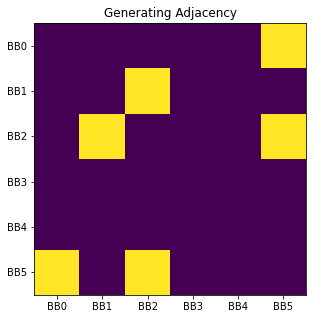

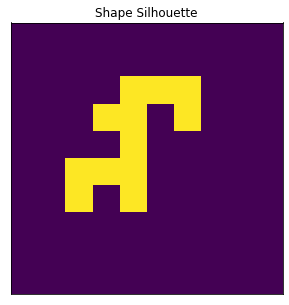

In [ ]:
# Association, same graph ( = correct prior)
ids = [1195,1197,1199,1203,1204]

# Association, different graph ( = incorrect prior)
# ids = [1210,1211,1214,1215,1223]

s = trial_df[trial_df['session_id'] == ids[-1]]["silhouette"].to_numpy()

# print first solution
print(s[0])

# readout building block pattern from text representation in trial_df["silhouette"] for first trial
BBs = make_ShapeCoord(s[0],4,start_pos=4)

# Finally, obtain adjacency for this trial
adjacency,BB_built,_ = draw_silh(BBs)

tick_Lab_short = ["BB0","BB1","BB2","BB3","BB4","BB5"]
plt.rcParams['figure.figsize'] = [5, 5]

plt.imshow(adjacency)
plt.title('Generating Adjacency')
plt.yticks([0,1,2,3,4,5], tick_Lab_short)
plt.xticks([0,1,2,3,4,5], tick_Lab_short)
plt.show()

plt.imshow(BB_built)
plt.title('Shape Silhouette')
plt.yticks([])
plt.xticks([])
plt.show()